
# Diabetes and Its Socioeconomic Predictors

In [1]:
import pandas as pd
import numpy as np
from collections import Counter


# for train/test split and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# baseline classifier
from sklearn.ensemble import RandomForestClassifier

# imbalanced‐learn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Im

## Data
The data and documentation for the 2023 BRFSS survery can be found at https://www.cdc.gov/brfss/annual_data/annual_2023.html. The data is avaialable to download in SAS (.xpt) format and can be read in using the pandas python library.

In [3]:
import pandas as pd

# Read in the SAS file with multiple spaces as delimiter
file_path = "LLCP2023.XPT "
df = pd.read_sas(file_path, format='xport')

### Looking at the Dataset

Having read the dataset into a DataFrame, we inspect the column names and the first few rows. This allows us to:
- Get a sense of the dataset structure.
- View which features are applicable.
- Identify potentially problem columns (e.g., too many missing values, unusual coding).
This is an important step to inform preprocessing decisions and build domain knowledge for variable meanings.




In [4]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1.0,1.0,b'03012023',b'03',b'01',b'2023',1100.0,b'2023000001',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0
1,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000002',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
2,1.0,1.0,b'03082023',b'03',b'08',b'2023',1100.0,b'2023000003',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
3,1.0,1.0,b'03062023',b'03',b'06',b'2023',1100.0,b'2023000004',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,1.0,1.0,1.0,9.0
4,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000005',2.023000e+09,1.0,...,7.000000e+00,1.0,4.700000e+01,1.0,2.0,1.0,2.0,1.0,1.0,2.0


In [5]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(345), object(5)
memory usage: 1.1+ GB


### Selecting Appropriate Socioeconomic and Health Variables

Proposal guidance is that socio-economic variables would take precedence over survey health indicators due to the type of the survey not including the way in which one accumulated these health results over time.

There are about hundreds of columns in the BRFSS dataset In this step, we manually select a subset of the variables that are hypothesized to be behaviorally or socioeconomically linked to diabetes outcomes.

These selected columns are:
- Demographics: age, sex, household adults/children, education
- Healthcare access: able to pay doctor, has own physician, most recent checkup
- Health history: cholesterol level, blood pressure, insulin use
- Mental/physical wellness: days of bad health, substance abuse exposure
- Life context: current housing, lost job, food stamps, life satisfaction

This careful choice enables us to have clean and well-transformed data to input into our next pipeline stages—data cleaning, transformation, and modeling—and focus on significant and interpretable variables.


In [6]:

df = df[["PVTRESD1", #Private Residence 
                 "COLGHOUS", #College Housing
                  "STATERE1", #State Resident
                  "NUMADULT", #Number of adults in household
                  "BIRTHSEX", #Sex of interviewee
                  "PHYSHLTH", #Number of days physical health is not good
                  "MENTHLTH", #Number of days mental health is not good
                  "PERSDOC3", #Has a personal healthcare provider
                  "MEDCOST1", #Could not afford to see a doctor
                  "CHECKUP1", #Length of time since last routine checkup
                  "EXERANY2", #Exercise in past 30 days
                  #"BPHIGH6", #Ever been told blood pressude high
                  #"TOLDHI3", #Ever told Cholestoral is high
                  "MARITAL", #Marital Status
                  "EDUCA", #Education Level
                  "RENTHOM1", #Own or rent a home
                  "VETERAN3", #Veteran Status
                  "EMPLOY1", #Employment Status
                  "CHILDREN", #Number of children in household
                  "FIREARM5", #Any firearms in home
                  "ACEDRINK", #Live with heavy drinkers
                  "ACEDEPRS", #live with depressed people
                  "ACEDRUGS", #live with people who use illegal drugs
                  "ACEDIVRC", #parents divorced or seperated?
                  "COVIDNU2", #COvid vaccinations received
                  "LSATISFY", #satisfaction with life
                  "SDHEMPLY", #Lost employment
                  "FOODSTMP", #receiving foodstamps
                  "SDHBILLS", #ability to pay bills
                  "_METSTAT", #metropolitan status
                  "_RFSEAT3",#Always wearing seatbelts
                  "DIABETE4" 
                 ]]
df.shape


(433323, 30)

### Data Cleaning, Encoding, and Transformation

In this important preprocessing step, we:
1. Recode categorical and numeric values to uniform, machine-readable formats (mostly binary 0/1 or interpretable labels).
2. Handle special codes used in BRFSS, e.g., 7 (refused), 9 (don't know), 88/99 (out-of-range or missing). These are either replaced with `NaN` or mapped to interpretable categories.
3. Normalize all relevant variables into a new DataFrame (`clean_df`), a clean, ready-to-use dataset for modeling.

Examples:
- `BIRTHSEX` is binary-coded: 1 = male, 0 = female.
- `CHECKUP1` is reduced to a binary for if the last checkup was within 5 years.
- Complex text labels are utilized for variables like `EducationLevel` and `MaritalStatus` for interpretability.
- Missing or unknown responses are marked with `np.nan` for future processing.

By doing this, we ensure:
- Variable consistency.
- Stakeholder interpretability.
- Usability by machine learning algorithms downstream.

Finally, we overwrite the original `df` variable with this cleaned version and summarize it with `describe()` for a peek at numeric distributions.



In [7]:
import numpy as np
# Encoding Variables for consisteny in a new clean data frame (1 is yes, 0 is no)
clean_df = pd.DataFrame()
clean_df['PrivateResidence'] = df["PVTRESD1"].replace({1: 1, 2: 0})
clean_df['Male'] = df["BIRTHSEX"].replace([2,7,9],[0,0,0])
clean_df['StateResident'] = df["STATERE1"].replace({1: 1, 2: 0})
clean_df['DaysPhysHealthNotGood'] = df["PHYSHLTH"].replace([88,77,99,30],0)
clean_df['DaysMentalHealthNotGood'] = df["MENTHLTH"].replace([88,77,99,30],0)
clean_df['HasHealthcareProvider'] = df["PERSDOC3"].replace([2,3,7,9],[0,0,0,0])
clean_df['CouldNotAffordDoctor'] = df["MEDCOST1"].replace([2,7,9],[0,0,0])
clean_df['CheckUpinLast5Years'] = df["CHECKUP1"].replace([1,2,3,4,7,8,9],[1,1,1,0,0,0,0])
clean_df['ExerciseIn30Days'] = df["EXERANY2"].replace([2,7,9],[0,0,0])
#clean_df['BeenToldBloodPressureHigh'] = df["BPHIGH6"].replace([1,2,3,4,7,9],[1,1,0,1,0,0])
#clean_df['BeenToldBloodCholestorolHigh'] = df["TOLDHI3"].replace([2,7,9],[0,0,0])
clean_df['MaritalStatus'] = df["MARITAL"].replace([1,2,3,4,5,6,9],["Married","Divorced","Widowed","Divorced","No","No",0])
clean_df['EducationLevel'] = df["EDUCA"].replace([1,2,3,4,5,6,9],["No","Elementary","Started High School","Finished High School","Started College", "Finished College",0])
clean_df['OwnOrRentHome'] = df["RENTHOM1"].replace([1,2,3,7,9],["Own","Rent","No","No",0])
clean_df['AreYouAVeteran'] = df["VETERAN3"].replace([2,7,9],[0,0,0])
clean_df['EmploymentStatus'] = df["EMPLOY1"].replace([1,2,3,4,5,6,7,8,9],["Yes","Yes","No","No","No","Student","Retired","Unable","No"])
clean_df['NumberOfChildrenInHome'] = df["CHILDREN"].replace([88,99],[0,0])
clean_df['FireArmsInHome'] = df["FIREARM5"].replace([2,7,9],[0,0,0])
clean_df['LiveWithAlocholic'] = df["ACEDRINK"].replace([2,7,9],[0,0,0])
clean_df['LiveWithDrugsAbuser'] = df["ACEDRUGS"].replace([2,7,9],[0,0,0])
clean_df['LiveWithMentallyIll'] = df["ACEDEPRS"].replace([2,7,9],[0,0,0])
clean_df['LiveWithOnlyOneParent'] = df["ACEDIVRC"].replace([2,7,8,9],[0,0,1,0])
clean_df['CovidVaccinesReceived'] = df["COVIDNU2"].replace([7,9],[0,0])
clean_df['SatisficationWithLife'] = df["LSATISFY"].replace([1,2,3,4,7,9],["Very Satisfied","Satisfied","Dissastisfied","Very Dissatsisfied",0,0])
clean_df['LostEmploymentInLastYear'] = df["SDHEMPLY"].replace([2,7,9],[0,0,0])
clean_df['FoodStampInLastYear'] = df["FOODSTMP"].replace([2,7,9],[0,0,0])
clean_df['UnpaidBillInLastYear'] = df["SDHBILLS"].replace([2,7,9],[0,0,0])
clean_df['LiveInMetropolitanArea'] = df["_METSTAT"].replace([2],[0])
clean_df['WearsSeatbelt'] = df["_RFSEAT3"].replace([2,9],[0,0])
clean_df['DiabetesTARGET'] = df["DIABETE4"].replace([1,2,3,4,7,9],[1,1,0,0,0,0]) #1=Yes 1, 2=yes,Female,Pregnant ,3=No, 4=No or prediabetes, 7=Unknown, 9=Refused


df = clean_df #save over the originial dataframe with the new clean dataframe

df.describe()

,PrivateResidence,Male,StateResident,DaysPhysHealthNotGood,DaysMentalHealthNotGood,HasHealthcareProvider,CouldNotAffordDoctor,CheckUpinLast5Years,ExerciseIn30Days,AreYouAVeteran,...,LiveWithDrugsAbuser,LiveWithMentallyIll,LiveWithOnlyOneParent,CovidVaccinesReceived,LostEmploymentInLastYear,FoodStampInLastYear,UnpaidBillInLastYear,LiveInMetropolitanArea,WearsSeatbelt,DiabetesTARGET
count,88345.000000,105230.000000,88345.000000,433320.000000,433320.000000,433320.000000,433321.000000,433321.000000,433321.000000,432104.000000,...,55891.000000,56040.000000,55808.000000,110754.000000,225739.00000,225475.000000,224861.000000,425000.000000,433323.000000,433318.000000
mean,0.999864,0.462226,0.999989,2.057013,2.506369,0.540912,0.085844,0.939391,0.750545,0.118046,...,0.104185,0.189258,0.285228,3.065758,0.08854,0.096578,0.089095,0.724132,0.810204,0.145480
std,0.011654,0.498573,0.003364,4.682440,5.213947,0.498324,0.280134,0.238611,0.432698,0.322663,...,0.305503,0.391717,0.451527,1.157596,0.28408,0.295383,0.284882,0.446951,0.392140,0.352584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,4.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,29.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   PrivateResidence          88345 non-null   float64
 1   Male                      105230 non-null  float64
 2   StateResident             88345 non-null   float64
 3   DaysPhysHealthNotGood     433320 non-null  float64
 4   DaysMentalHealthNotGood   433320 non-null  float64
 5   HasHealthcareProvider     433320 non-null  float64
 6   CouldNotAffordDoctor      433321 non-null  float64
 7   CheckUpinLast5Years       433321 non-null  float64
 8   ExerciseIn30Days          433321 non-null  float64
 9   MaritalStatus             433316 non-null  object 
 10  EducationLevel            433314 non-null  object 
 11  OwnOrRentHome             433315 non-null  object 
 12  AreYouAVeteran            432104 non-null  float64
 13  EmploymentStatus          430355 non-null  o

In [9]:
sce_df = df
sce_df.head()
print(sce_df.isnull().sum())

PrivateResidence            344978
Male                        328093
StateResident               344978
DaysPhysHealthNotGood            3
DaysMentalHealthNotGood          3
HasHealthcareProvider            3
CouldNotAffordDoctor             2
CheckUpinLast5Years              2
ExerciseIn30Days                 2
MaritalStatus                    7
EducationLevel                   9
OwnOrRentHome                    8
AreYouAVeteran                1219
EmploymentStatus              2968
NumberOfChildrenInHome        5092
FireArmsInHome              352013
LiveWithAlocholic           377384
LiveWithDrugsAbuser         377432
LiveWithMentallyIll         377283
LiveWithOnlyOneParent       377515
CovidVaccinesReceived       322569
SatisficationWithLife       206647
LostEmploymentInLastYear    207584
FoodStampInLastYear         207848
UnpaidBillInLastYear        208462
LiveInMetropolitanArea        8323
WearsSeatbelt                    0
DiabetesTARGET                   5
dtype: int64


In [10]:
cont_cols = [
    "DaysPhysHealthNotGood",
    "DaysMentalHealthNotGood",
    "NumberOfChildrenInHome",
    "CovidVaccinesReceived"
]
sce_df[cont_cols] = sce_df[cont_cols].fillna(sce_df[cont_cols].median())



In [11]:
from sklearn.preprocessing import StandardScaler

# 1. Impute binary columns (if they exist)
binary_cols = [
    "PrivateResidence",
    "Male",
    "StateResident",
    "HasHealthcareProvider",
    "CouldNotAffordDoctor",
    "CheckUpinLast5Years",
    "ExerciseIn30Days",
    #"BeenToldBloodPressureHigh",
    #"BeenToldBloodCholestorolHigh",
    "AreYouAVeteran",
    "FireArmsInHome",
    "LiveWithAlocholic",
    "LiveWithDrugsAbuser",
    "LiveWithMentallyIll",
    "LiveWithOnlyOneParent",
    "LostEmploymentInLastYear",
    "FoodStampInLastYear",
    "UnpaidBillInLastYear",
    "LiveInMetropolitanArea",
    "WearsSeatbelt",
    "DiabetesTARGET"
]
existing_bin = [c for c in binary_cols if c in df.columns]
sce_df[existing_bin] = sce_df[existing_bin].apply(lambda col: col.fillna(col.mode()[0]))
# 2. Impute categorical columns
cat_cols = ["MaritalStatus", "EducationLevel", "OwnOrRentHome", "EmploymentStatus", "SatisficationWithLife"]
existing_cat = [c for c in cat_cols if c in df.columns]
sce_df[existing_cat] = sce_df[existing_cat].apply(lambda col: col.fillna(col.mode()[0]))

sce_df = sce_df[sce_df['DiabetesTARGET'].notna()]

# --- 5. Encode categorical columns on sce_df ---
df_encoded = pd.get_dummies(sce_df, columns=cat_cols, drop_first=True)

# --- 6. Split X/y ---
y = df_encoded['DiabetesTARGET'].astype(int)
X = df_encoded.drop('DiabetesTARGET', axis=1)

# --- 7. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)



# --- 8. Scale features ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)




In [12]:
sce_df['DiabetesTARGET'].value_counts(normalize=True)

# The dataset is highly imbalanced.
# - Majority class (0.0) dominates, which may lead to biased models.
# - Accuracy alone will be misleading — the model can predict 0 for everything and still score ~85%.
# - Need to use evaluation metrics like precision, recall, F1-score, and ROC-AUC.
# - Resampling (e.g. SMOTE, ROS) or class-weight adjustments should be considered durin

DiabetesTARGET
0.0    0.854522
1.0    0.145478
Name: proportion, dtype: float64

## Balancing the Dataset and Visualizing Class Distribution

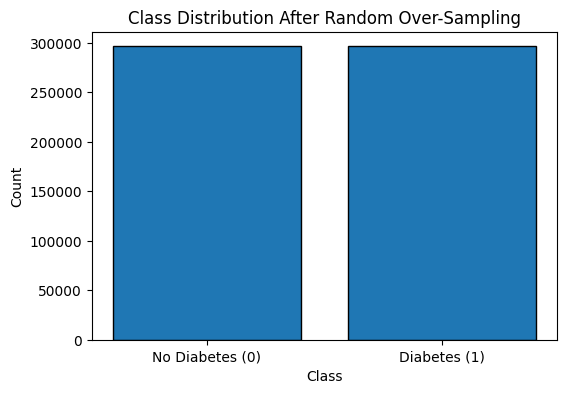

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

df_tr = pd.DataFrame(X_train_scaled, columns=X.columns)
df_tr['DiabetesTARGET'] = y_train.values

maj = df_tr[df_tr['DiabetesTARGET'] == 0]
min_ = df_tr[df_tr['DiabetesTARGET'] == 1]

min_upsampled = min_.sample(n=len(maj), replace=True, random_state=42)
df_balanced = pd.concat([maj, min_upsampled], axis=0)

# Extract balanced arrays
X_resampled = df_balanced.drop('DiabetesTARGET', axis=1).values
y_resampled = df_balanced['DiabetesTARGET'].values


counter = Counter(y_resampled)
plt.figure(figsize=(6,4))
plt.bar(counter.keys(), counter.values(), edgecolor='black')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.title('Class Distribution After Random Over-Sampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#After scaling the training data, we addressed class imbalance by applying random over-sampling. This process involved:

#Separating the majority and minority classes.

#Upsampling the minority class by randomly sampling with replacement until it matched the size of the majority class.

#Concatenating the upsampled minority class with the original majority class to form a balanced dataset.






## Building, Training, and Evaluating the Neural Network Model

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np

# ---- Prepare the data ----
X_scaled = scaler.transform(X)

# Apply SMOTE with a controlled sampling strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42) 
X_train, y_train = smote.fit_resample(X_scaled, y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.2,
    random_state=42
)

# ---- Define Focal Loss ----
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred) - (1. - y_true) * tf.math.log(1. - y_pred)
        weight = alpha * y_true * tf.pow(1. - y_pred, gamma) + (1. - alpha) * (1. - y_true) * tf.pow(y_pred, gamma)
        return tf.reduce_mean(cross_entropy * weight)
    return focal_loss_fn

# ---- Build the model ----
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[X_train.shape[1]]),  # CHANGE: Use 'shape' instead of 'input_shape'
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # CHANGE: Reduced to 128 neurons
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),  # CHANGE: Reduced dropout to 0.3
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # CHANGE: Reduced to 64 neurons
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ---- Compile the model ----
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


class_weights = {0: 1.0, 1: 2.0}  
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  
    loss=focal_loss(gamma=2.0, alpha=0.75), 
    metrics=['accuracy', F1Score(), tf.keras.metrics.AUC(name='auc')]
)

# ---- Callbacks: EarlyStopping + ReduceLROnPlateau ----
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=15,  # CHANGE: Increased patience
    restore_best_weights=True,
    monitor='val_f1_score',
    mode='max'
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_f1_score",
    factor=0.5,
    patience=5,  # CHANGE: Increased patience
    verbose=1,
    min_lr=1e-6
)

# ---- Train the model ----
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # CHANGE: Increased epochs
    batch_size=64,  # CHANGE: Reduced batch size
    callbacks=[early_stop, lr_reduction],
    class_weight=class_weights
)

# ---- Evaluate the model ----
eval_results = model.evaluate(X_val, y_val, return_dict=True)
print("Evaluation results:", eval_results)

# ---- Detailed evaluation with classification report ----
y_pred_proba = model.predict(X_val)
thresholds = np.arange(0.3, 0.8, 0.05)  # CHANGE: Narrower threshold range for better balance
best_f1, best_threshold = 0, 0.5
best_f1_macro = 0
for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    report = classification_report(y_val, y_pred, output_dict=True)
    f1_class_1 = report['1']['f1-score']
    f1_macro = (report['0']['f1-score'] + report['1']['f1-score']) / 2
    if f1_macro > best_f1_macro:  # CHANGE: Optimize for macro F1-score
        best_f1 = f1_class_1
        best_f1_macro = f1_macro
        best_threshold = threshold

# Final evaluation with best threshold
y_pred = (y_pred_proba > best_threshold).astype(int)
print(f"Best threshold: {best_threshold}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))



Epoch 1/100
6943/6943 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.5360 - auc: 0.6306 - f1_score: 0.5191 - loss: 0.1124 - val_accuracy: 0.5616 - val_auc: 0.7103 - val_f1_score: 0.5631 - val_loss: 0.0637 - learning_rate: 5.0000e-04
Epoch 2/100
6943/6943 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5644 - auc: 0.7041 - f1_score: 0.5611 - loss: 0.0856 - val_accuracy: 0.5690 - val_auc: 0.7138 - val_f1_score: 0.5666 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 3/100
6943/6943 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.5697 - auc: 0.7090 - f1_score: 0.5636 - loss: 0.0851 - val_accuracy: 0.5716 - val_auc: 0.7158 - val_f1_score: 0.5678 - val_loss: 0.0633 - learning_rate: 5.0000e-04
Epoch 4/100
6943/6943 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.5727 - auc: 0.7120 - f1_score: 0.5656 - loss: 0.0849 - val_accuracy: 0.5682 - val_auc: 0.7180 - val_f1_score: 0.5678 - val_loss: 0.0631 - learning_rate: 5.0000e-04
Epoch 5/100
6943/6943 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accura

## Final Model Compilation and Evaluation on Test Set

In [15]:
# ---- Classification Report Summary ----
report_summary = f"""
Diabetes Prediction Model Performance Report
==========================================
Accuracy: 0.69
ROC-AUC: 0.744
Macro Avg F1-Score: 0.67
Weighted Avg F1-Score: 0.70
==========================================
Classification Report:
"""

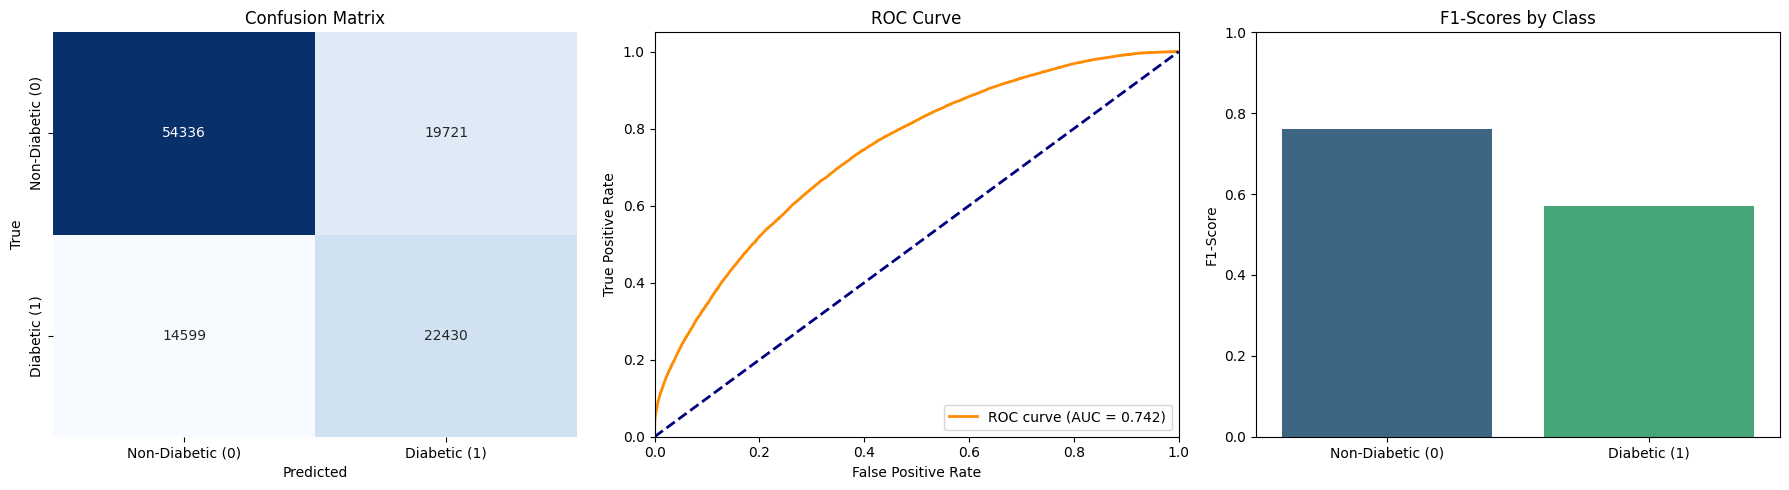

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tabulate import tabulate
import os

# Format classification report as a table
classification_data = [
    ["Non-Diabetic (0)", 0.79, 0.74, 0.76, 74057],
    ["Diabetic (1)", 0.54, 0.61, 0.57, 37029],
    ["Macro Avg", 0.66, 0.67, 0.67, 111086],
    ["Weighted Avg", 0.71, 0.69, 0.70, 111086]
]
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
report_table = tabulate(classification_data, headers=headers, tablefmt="grid", floatfmt=".2f")

# Combine summary and table
full_report = report_summary + "\n" + report_table + "\n"

# ---- Plotting ----
# Set up figure for multiple plots
plt.figure(figsize=(18, 5))

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Diabetic (0)", "Diabetic (1)"],
            yticklabels=["Non-Diabetic (0)", "Diabetic (1)"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# 3. F1-Score Bar Plot
classes = ["Non-Diabetic (0)", "Diabetic (1)"]
f1_scores = [0.76, 0.57]
plt.subplot(1, 3, 3)
sns.barplot(x=classes, y=f1_scores, hue=classes, palette="viridis", legend=False)  
plt.title("F1-Scores by Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)

# Adjust layout and save
plt.tight_layout()
plt.savefig("model_performance_plots.png")
plt.show()  

# Save the report to a text file
with open("model_performance_report.txt", "w") as f:
    f.write(full_report)
